In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

https://www.kaggle.com/discussions/general/74235
follow instructions

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
#kaggle datasets download -d tusharpadhy/deepfake-dataset

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cecilia0999","key":"cc1406dbb42304ade9f37c8885076ba5"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d tusharpadhy/deepfake-dataset


ref                                                                     title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                                     Online Food Dataset                                  3KB  2024-03-02 18:50:30          14860        305  0.9411765        
kanchana1990/world-air-quality-data-2024-updated                        World Air Quality Data 2024 (Updated)                2MB  2024-03-25 15:10:07           1465         40  1.0              
sukhmandeepsinghbrar/car-price-prediction-dataset                       Car Price Prediction Dataset                       141KB  2024-03-28 08:27:39            638         25  1.0              
prishasawhney/imdb-datase

In [ ]:
! mkdir dataset
! unzip deepfake-dataset.zip -d dataset

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Setup datasets
train_dataset = datasets.ImageFolder('/content/dataset/train', transform=transform)
val_dataset = datasets.ImageFolder('/content/dataset/valid', transform=transform)
test_dataset = datasets.ImageFolder('/content/dataset/test', transform=transform)

# Setup data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

240002
59428
30905


GoogLeNet Architecture Cited from: https://medium.com/@AnasBrital98/googlenet-cnn-architecture-explained-inception-v1-225ae02513fd
and https://github.com/KhuyenLE-maths/Implementation-of-GoogLeNet-on-Keras/blob/main/Implementation_of_GoogLeNet_on_Keras.ipynb

ResNet50 Model Cited from: https://medium.com/@karuneshu21/how-to-resnet-in-pytorch-9acb01f36cf5


Citations are also cite in the reference list in the final report, model structures and hyperparameters are tuned to suit our project.



In [ ]:

import torch

# all nn libraries nn.layer, convs and loss functions
import torch.nn as nn

# Display Image
from IPython.display import Image

# visualisation
!pip install torchview
import torchvision
from torchview import draw_graph


# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# resnetX = (Num of channels, repetition, Bottleneck_expansion , Bottleneck_layer)
model_parameters={}
model_parameters['resnet50'] = ([64,128,256,512],[3,4,6,3],4,True)

In [ ]:
import torch
import torch.nn as nn

class Bottleneck(nn.Module):
    def __init__(self, in_channels, intermediate_channels, expansion, is_Bottleneck, stride):
        super(Bottleneck, self).__init__()

        self.expansion = expansion
        self.is_Bottleneck = is_Bottleneck
        out_channels = intermediate_channels * expansion
        self.identity = stride == 1 and in_channels == out_channels

        if not self.identity:
            self.projection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.projection = None

        self.relu = nn.ReLU(inplace=True)

        if is_Bottleneck:
            self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, bias=False)
            self.bn1 = nn.BatchNorm2d(intermediate_channels)
            self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(intermediate_channels)
            self.conv3 = nn.Conv2d(intermediate_channels, out_channels, kernel_size=1, bias=False)
            self.bn3 = nn.BatchNorm2d(out_channels)
        else:
            self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(intermediate_channels)
            self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(intermediate_channels)

    def forward(self, x):
        identity = x

        if self.is_Bottleneck:
            out = self.relu(self.bn1(self.conv1(x)))
            out = self.relu(self.bn2(self.conv2(out)))
            out = self.bn3(self.conv3(out))
        else:
            out = self.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))

        if self.projection is not None:
            identity = self.projection(identity)

        out += identity
        out = self.relu(out)

        return out


torch.Size([1, 256, 56, 56])


In [ ]:
import torch
import torch.nn as nn

class ResNet(nn.Module):
    def __init__(self, resnet_variant, in_channels, num_classes=1):
        super(ResNet, self).__init__()

        self.channels_list = resnet_variant[0]
        self.repetition_list = resnet_variant[1]
        self.expansion = resnet_variant[2]
        self.is_Bottleneck = resnet_variant[3]

        # Initial Convolution and MaxPool
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet Blocks
        self.block1 = self._make_blocks(64, self.channels_list[0], self.repetition_list[0], stride=1)
        self.block2 = self._make_blocks(self.channels_list[0] * self.expansion, self.channels_list[1], self.repetition_list[1], stride=2)
        self.block3 = self._make_blocks(self.channels_list[1] * self.expansion, self.channels_list[2], self.repetition_list[2], stride=2)
        self.block4 = self._make_blocks(self.channels_list[2] * self.expansion, self.channels_list[3], self.repetition_list[3], stride=2)

        # Adaptive Average Pooling and Final Fully Connected Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.channels_list[3] * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def _make_blocks(self, in_channels, out_channels, repetitions, stride):
        blocks = []
        # First block with specified stride
        blocks.append(Bottleneck(in_channels, out_channels, self.expansion, self.is_Bottleneck, stride=stride))
        # Remaining blocks with stride 1
        for _ in range(1, repetitions):
            blocks.append(Bottleneck(out_channels * self.expansion, out_channels, self.expansion, self.is_Bottleneck, stride=1))

        return nn.Sequential(*blocks)


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm  # Import tqdm

def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Dictionary to store training and validation losses and accuracies
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        # Training phase with progress bar
        train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
        for inputs, labels in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update training loss and accuracy
            train_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs.squeeze()) > 0.5
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            # Update progress bar with the current loss
            train_progress.set_postfix(loss=loss.item())

        # Validation phase with progress bar
        val_loss, val_correct, val_total = 0, 0, 0
        val_progress = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]', leave=True)
        with torch.no_grad():
            model.eval()
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())

                # Update validation loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs.squeeze()) > 0.5
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        # Calculate average loss and accuracy over the epoch
        train_loss /= train_total
        train_acc = train_correct / train_total
        val_loss /= val_total
        val_acc = val_correct / val_total

        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Update history dictionary with the metrics of the current epoch
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    return history


In [ ]:

# Define the model
architecture = 'resnet50'
params = model_parameters[architecture]
model = ResNet(params, in_channels=3, num_classes=1)

# Number of epochs
num_epochs = 10

# Train the model
history = train_model(model, train_loader, val_loader, num_epochs=num_epochs)


Epoch 1/10 [Validation]: 100%|██████████| 1858/1858 [02:44<00:00, 11.31it/s]



Epoch 1/10, Train Loss: 0.5009, Train Acc: 0.7300, Val Loss: 0.3425, Val Acc: 0.8452


Epoch 2/10 [Validation]: 100%|██████████| 1858/1858 [02:40<00:00, 11.60it/s]



Epoch 2/10, Train Loss: 0.2391, Train Acc: 0.8990, Val Loss: 0.2278, Val Acc: 0.9050


Epoch 3/10 [Validation]: 100%|██████████| 1858/1858 [02:44<00:00, 11.32it/s]



Epoch 3/10, Train Loss: 0.1528, Train Acc: 0.9386, Val Loss: 0.1681, Val Acc: 0.9315


Epoch 4/10 [Validation]: 100%|██████████| 1858/1858 [02:40<00:00, 11.57it/s]



Epoch 4/10, Train Loss: 0.1104, Train Acc: 0.9563, Val Loss: 0.1471, Val Acc: 0.9398


Epoch 5/10 [Validation]: 100%|██████████| 1858/1858 [02:41<00:00, 11.48it/s]



Epoch 5/10, Train Loss: 0.0832, Train Acc: 0.9679, Val Loss: 0.1250, Val Acc: 0.9521


Epoch 6/10 [Validation]: 100%|██████████| 1858/1858 [02:40<00:00, 11.61it/s]



Epoch 6/10, Train Loss: 0.0652, Train Acc: 0.9747, Val Loss: 0.1311, Val Acc: 0.9504


Epoch 7/10 [Validation]: 100%|██████████| 1858/1858 [02:40<00:00, 11.57it/s]



Epoch 7/10, Train Loss: 0.0530, Train Acc: 0.9794, Val Loss: 0.1400, Val Acc: 0.9485


Epoch 8/10 [Validation]: 100%|██████████| 1858/1858 [02:43<00:00, 11.35it/s]



Epoch 8/10, Train Loss: 0.0437, Train Acc: 0.9831, Val Loss: 0.1136, Val Acc: 0.9605


Epoch 9/10 [Validation]: 100%|██████████| 1858/1858 [02:43<00:00, 11.39it/s]



Epoch 9/10, Train Loss: 0.0363, Train Acc: 0.9859, Val Loss: 0.1095, Val Acc: 0.9646


Epoch 10/10 [Validation]: 100%|██████████| 1858/1858 [02:44<00:00, 11.30it/s]


Epoch 10/10, Train Loss: 0.0309, Train Acc: 0.9881, Val Loss: 0.1083, Val Acc: 0.9648


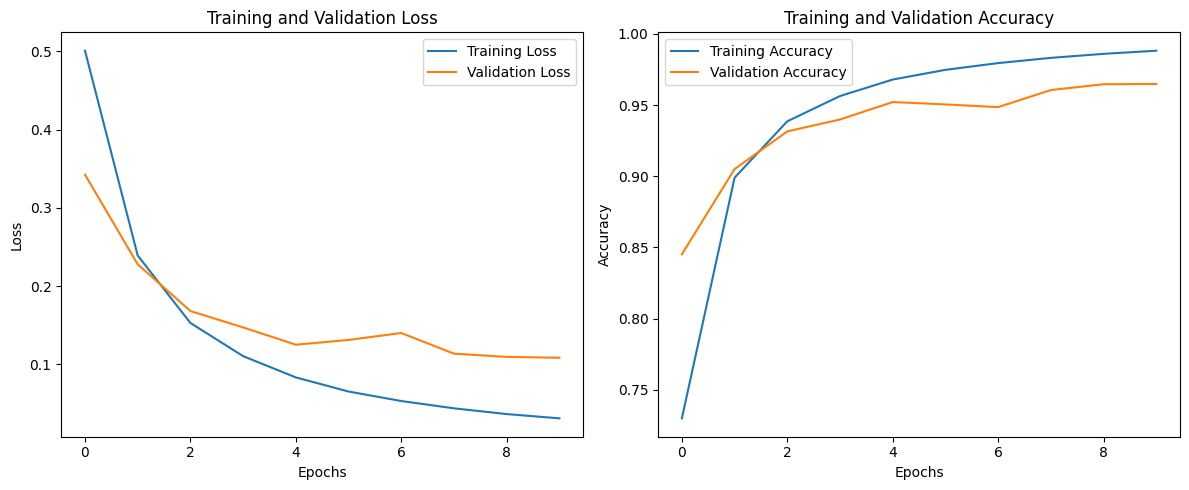

In [ ]:
# Plotting losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(model, criterion, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients required for evaluation, which saves memory and computations
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())  # Assuming binary classification with a single output unit
            test_loss += loss.item()

            # For binary classification, using a threshold of 0.5
            predicted = (outputs > 0.5).float()  # Using sigmoid threshold at 0.5
            total += targets.size(0)
            correct += (predicted == targets.unsqueeze(1)).sum().item()

    # Calculate average loss and accuracy
    test_loss /= len(test_loader.dataset)
    accuracy = correct / total

    return test_loss, accuracy


In [ ]:
criterion = nn.BCEWithLogitsLoss()
evaluate_model(model, criterion, test_loader, device)

0.1081 0.9632


In [ ]:
%%shell
jupyter nbconvert --to html /content/APS_360_project.ipynb

[NbConvertApp] Converting notebook /content/APS_360_project.ipynb to html
[NbConvertApp] Writing 979842 bytes to /content/APS_360_project.html
